In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')


X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [22]:

train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

In [23]:
import pandas as pd

pd.set_option('display.max_rows', 100)

# FILEPATH: /Users/lasse/Programming/Uni/MLProjectNTNU/new_preprocessing.ipynb



# Aggregating data

In [24]:
all_observed_X = pd.concat([X_train_observed_a,X_train_observed_b,X_train_observed_c])
all_estimated_X = pd.concat([X_train_estimated_a,X_train_estimated_b,X_train_estimated_c])

X_test = pd.concat([X_test_estimated_a,X_test_estimated_b,X_test_estimated_c])
X_train = pd.concat([all_observed_X,all_estimated_X])

y_train = pd.concat([train_a,train_b,train_c])

X_train['time'] = X_train['date_forecast'].dt.floor('H')
X_train_grouped = X_train.groupby(['building_id','time']).mean()

X_test['time'] = X_test['date_forecast'].dt.floor('H')
X_test_grouped = X_test.groupby(['building_id','time']).mean()

data_train = X_train_grouped.merge(y_train,on=['time','building_id'],how='left')


In [25]:
X_train.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='sun_elevation:d', ylabel='pv_measurement'>

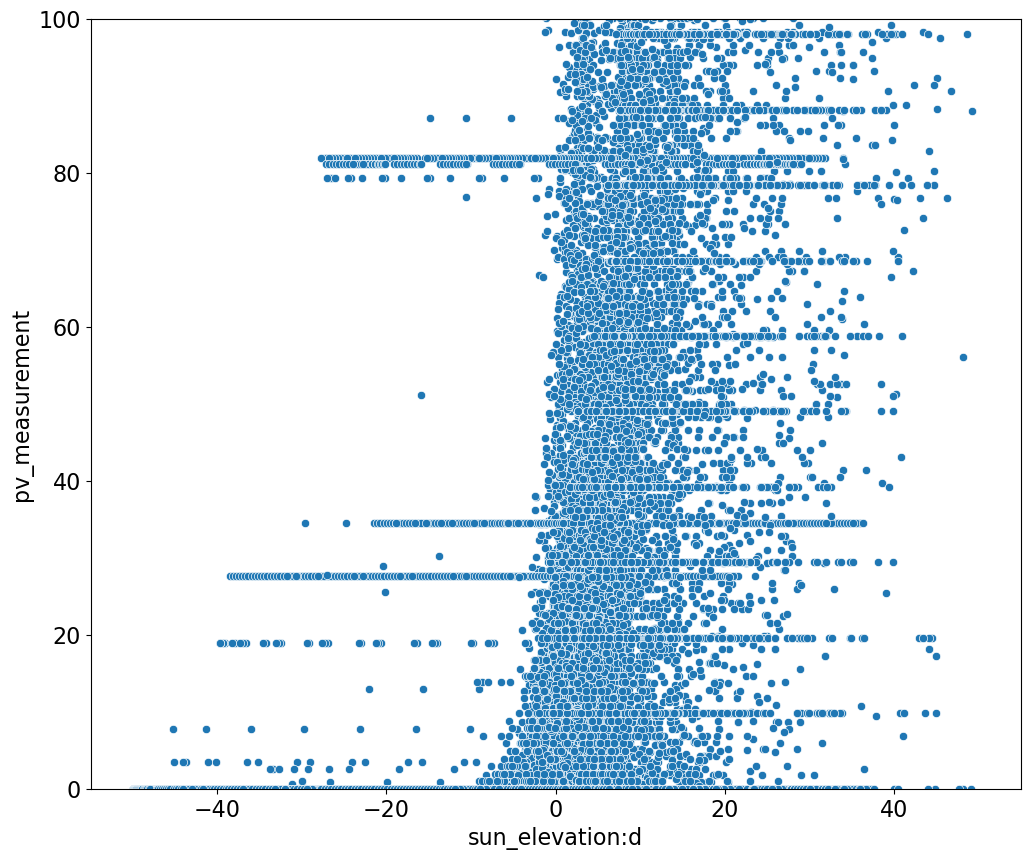

In [26]:

ax = plt.gca()
ax.set_ylim(0,100)
sns.scatterplot(data=data_train,x='sun_elevation:d',y='pv_measurement')

In [27]:
data_train[['sun_elevation:d','time','pv_measurement']].head(100)

,sun_elevation:d,time,pv_measurement
0,-3.774250,2019-06-02 22:00:00,0.00
1,-4.357250,2019-06-02 23:00:00,0.00
2,-3.309500,2019-06-03 00:00:00,0.00
3,-0.822500,2019-06-03 01:00:00,0.00
4,3.051250,2019-06-03 02:00:00,19.36
5,8.071000,2019-06-03 03:00:00,251.02
6,13.956500,2019-06-03 04:00:00,263.78
7,20.406250,2019-06-03 05:00:00,522.72
8,27.096001,2019-06-03 06:00:00,904.42
9,33.660751,2019-06-03 07:00:00,1238.82


# Some basic preprocessing

In [28]:
#Removing samples where there is not pv_measurement
data_train = data_train.dropna(subset=['pv_measurement'])

# DateTime removal
#Keeping only month and hour because more relevant for pv_measurement
#data_train['time_month'] = data_train['time'].dt.month
#data_train['time_hour'] = data_train['time'].dt.hour

X_test = X_test_grouped.reset_index()
#X_test['time_month'] = X_test['time'].dt.month
#X_test['time_hour'] = X_test['time'].dt.hour

#Snow density
data_train.drop('snow_density:kgm3',axis=1, inplace=True)
X_test.drop('snow_density:kgm3',axis=1, inplace=True)

#Elevation
data_train.drop('elevation:m',axis=1, inplace=True)
X_test.drop('elevation:m',axis=1, inplace=True)

#Cloud and ceiling
data_train['cloud_base_agl:m'].fillna(data_train['cloud_base_agl:m'].mean(), inplace=True)
data_train['ceiling_height_agl:m'].fillna(data_train['ceiling_height_agl:m'].mean(), inplace=True)

X_test['cloud_base_agl:m'].fillna(X_test['cloud_base_agl:m'].mean(), inplace=True)
X_test['ceiling_height_agl:m'].fillna(X_test['ceiling_height_agl:m'].mean(), inplace=True)

# Splitting observed and estimated (preprocess of date_calc)
data_train_o = data_train[data_train['date_calc'].isna()]
data_train_e = data_train[data_train['date_calc'].notna()]

pd.options.mode.chained_assignment = None
data_train_e['delta_forecasting'] = (data_train_e['time']-data_train_e['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_test['delta_forecasting'] = (X_test['time']-X_test['date_calc']).apply(lambda x: x.total_seconds() / 3600)

data_train.drop(columns=['time','date_forecast','date_calc'],inplace=True)
X_test.drop(columns=['time','date_forecast','date_calc'],inplace=True)

#Resetting indexes
data_train_o.reset_index(inplace=True,drop=True)
data_train_e.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

#One hot encoding
data_train_o = pd.get_dummies(data_train_o, columns=['building_id'], prefix=['id'],dtype=int)
data_train_e = pd.get_dummies(data_train_e, columns=['building_id'], prefix=['id'],dtype=int)
X_test = pd.get_dummies(X_test, columns=['building_id'], prefix=['id'],dtype=int)

# Correlated Feature


In [29]:
#Making assumption only on data_train_o, should be same also for other dataset
#corrmat = data_train_o.corr()

#groups
#groups = []
#assigned_features = set()
#for col in data_train_o.columns:
#    if col not in assigned_features:
#        highly_correlated_features = corrmat.index[corrmat[col].abs() > 0.6].tolist()
#        highly_correlated_features.remove(col)  # Remove col itself
#        if highly_correlated_features:
#            highly_correlated_group = [col] + highly_correlated_features
#            groups.append(highly_correlated_group)
#            assigned_features.update(highly_correlated_group)
            #if highly_correlated_group not in groups:
            #    groups.append(highly_correlated_group)

#for group in groups:
#    print(f"Group: {', '.join(group)}")

#groups that make sense
#Humidity Group: absolute_humidity_2m:gm3, air_density_2m:kgm3, dew_point_2m:K, t_1000hPa:K
#Clouds height Group: ceiling_height_agl:m, cloud_base_agl:m
#Sun Group: clear_sky_energy_1h:J, clear_sky_rad:W, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, is_day:idx, is_in_shadow:idx, sun_elevation:d
#Cloud cover Group: effective_cloud_cover:p, total_cloud_cover:p
#Snow Group: fresh_snow_12h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, fresh_snow_1h:cm,
#Pressure Group: msl_pressure:hPa, pressure_100m:hPa, pressure_50m:hPa, sfc_pressure:hPa

#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True)

In [30]:
#PCA function
def pca_analysis(df, features, feature_prefix, n_components, scalers):
    df = df.copy(deep=True)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])

    pca_transformer = PCA(n_components=n_components)
    df_pca = pd.DataFrame(pca_transformer.fit_transform(df_scaled))
    df_pca.columns = [feature_prefix + "_" + str(i+1) for i in range(n_components)]

    df = df.drop(features, axis=1)
    #df = pd.concat([df, df_pca], axis=1, ignore_index=True)
    df = pd.concat([df, pd.DataFrame(df_pca)], axis=1)
    

    scalers |= {feature_prefix: {'scaler': scaler, 'pca_transformer': pca_transformer}}

    return df, scalers

In [31]:
#Performing PCA on correlated groups
# define groups of variables

humidity_features_list = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K', 't_1000hPa:K']

cloud_height_features_list = ['ceiling_height_agl:m', 'cloud_base_agl:m']

sun_features_list = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

cloud_cover_features_list = ['effective_cloud_cover:p', 'total_cloud_cover:p']

snow_features_list = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

pressure_feature_list = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']

time_hour_features_list = ['time_hour', 'sun_azimuth:d']

all_groups = [humidity_features_list,cloud_height_features_list,sun_features_list,cloud_cover_features_list,snow_features_list,pressure_feature_list,time_hour_features_list]
all_groups_names = ['humidity','cloud_height','sun','cloud_cover','snow','pressure','time_hour']
n_pca = [2,1,3,1,2,2,1]

data_train_o_pca = data_train_o.copy()
scalers = {}

In [32]:
#Applying PCA 
#for group, name, n in zip(all_groups, all_groups_names, n_pca):
#    data_train_o_pca, scalers = pca_analysis(data_train_o_pca, group, name, n, scalers)

<Axes: >

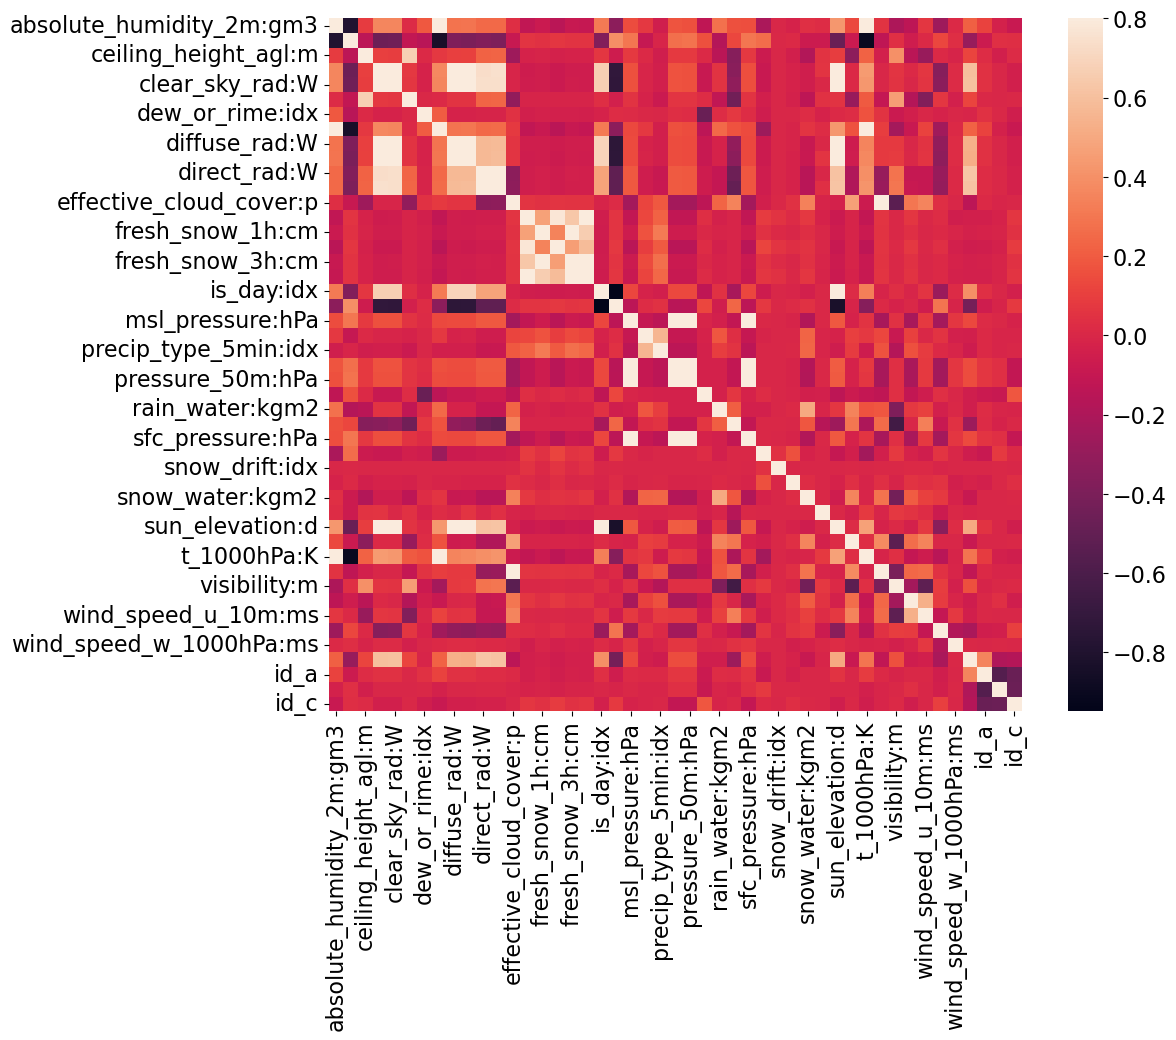

In [33]:
corrmat = data_train_o.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

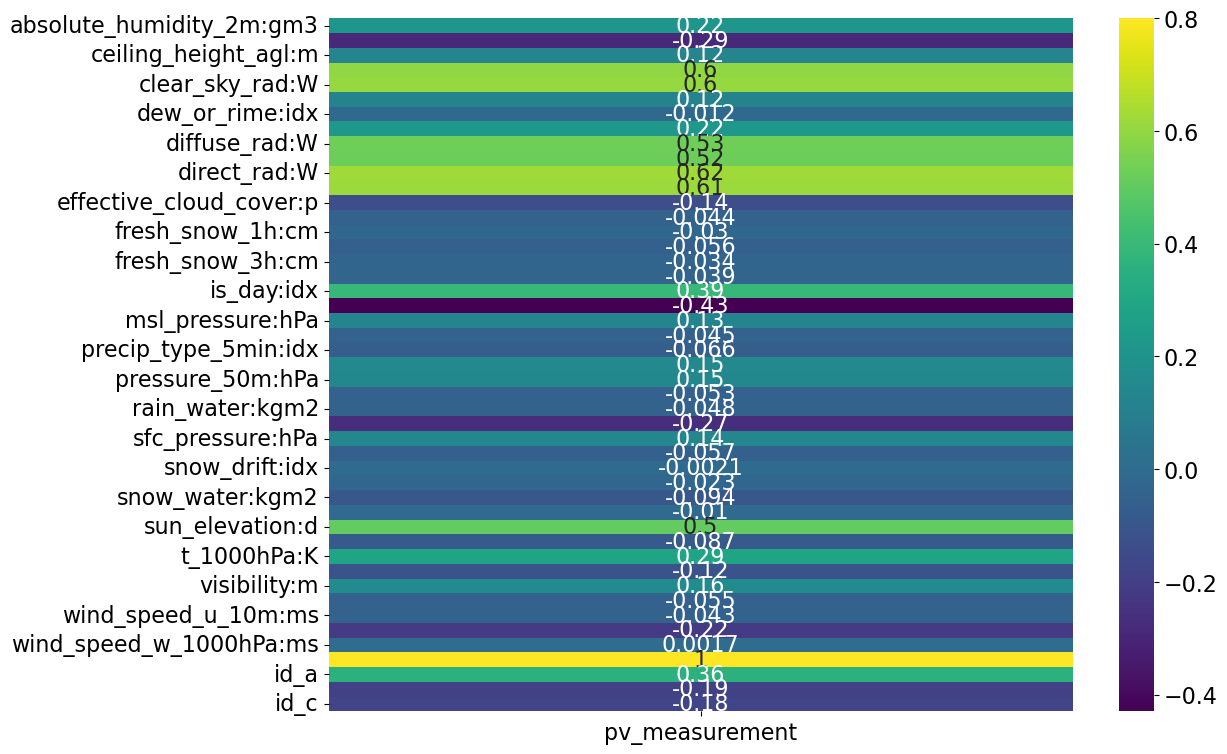

In [34]:
corr_y = data_train_o.corr(numeric_only=True)['pv_measurement'].to_frame()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_y, vmax=.8, cmap='viridis', annot=True);

In [35]:
# Keeping only 24h snow since is the most significant
#column_to_drop = ['fresh_snow_12h:cm','fresh_snow_1h:cm','fresh_snow_3h:cm','fresh_snow_6h:cm']

from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

data_train_o = data_train_o[data_train_o['pv_measurement']>0]
data_train_o = data_train_o.sort_values(by='date_forecast')

data_train_o.drop(columns=['date_forecast','time','date_calc'], inplace=True)

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(data_train_o) 
data_train_o.loc[:,:] = scaled_values

train = data_train_o[:31625]
test = data_train_o[31625:]

X_train = train.drop(columns='pv_measurement')
y_train = train['pv_measurement']

X_test = test.drop(columns='pv_measurement')
y_test = test['pv_measurement']



In [36]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=data_train_o.drop(columns='pv_measurement').columns)
lasso_coeff=lasso_coeff.sort_values('Feature Importance', ascending=True)

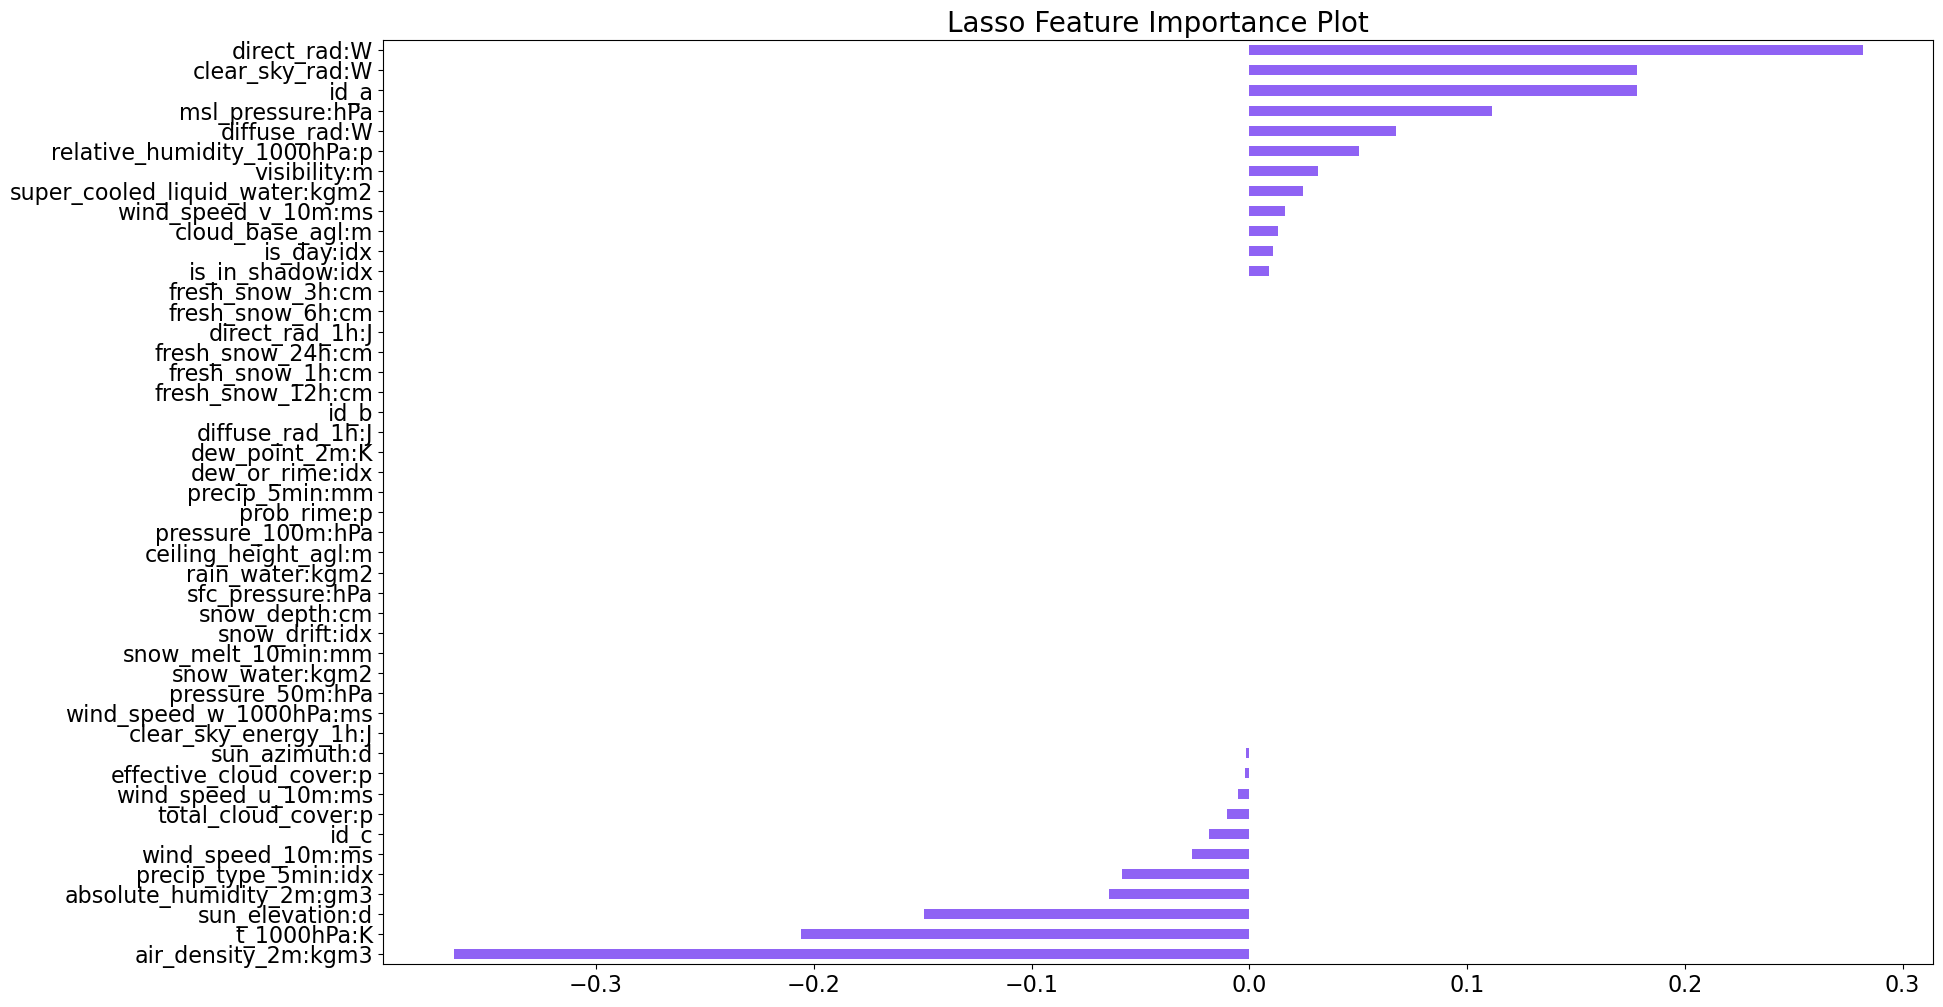

In [37]:
from IPython.core.pylabtools import figsize
import matplotlib

figsize(12, 10)
matplotlib.rcParams['font.size'] = 16

g = lasso_coeff['Feature Importance'].plot(kind='barh',figsize=(20,12), color='#8f63f4')
plt.title("Lasso Feature Importance Plot",fontsize=20)
plt.savefig(fname="Lasso_Feature_importance_plot",dpi=300)

In [38]:
col_drop = lasso_coeff[lasso_coeff['Feature Importance']==0].sort_values('Feature Importance').index.to_list()
col_drop.remove('id_b')

data_train_o.drop(columns=col_drop, inplace=True)

In [39]:
data_train_o = data_train_o.reset_index(drop=True)



In [40]:
col_drop

['clear_sky_energy_1h:J',
 'direct_rad_1h:J',
 'fresh_snow_24h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_12h:cm',
 'diffuse_rad_1h:J',
 'dew_point_2m:K',
 'dew_or_rime:idx',
 'precip_5min:mm',
 'fresh_snow_6h:cm',
 'prob_rime:p',
 'ceiling_height_agl:m',
 'rain_water:kgm2',
 'sfc_pressure:hPa',
 'snow_depth:cm',
 'snow_drift:idx',
 'snow_melt_10min:mm',
 'snow_water:kgm2',
 'pressure_50m:hPa',
 'wind_speed_w_1000hPa:ms',
 'pressure_100m:hPa',
 'fresh_snow_3h:cm']